In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [7]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [8]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [9]:
n = len(train_df); n

844338

### Experimenting with a sample

In [10]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

^^ grab a subset to play around with

In [11]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
42,43,5,"Jan,Apr,Jul,Oct",4880.0,61,8096
140,141,5,"Mar,Jun,Sept,Dec",1540.0,51,8689
702,704,5,NaN,1910.0,61,12620
1336,224,4,"Jan,Apr,Jul,Oct",7930.0,60,9351
1906,795,4,"Mar,Jun,Sept,Dec",510.0,73,4996


In [12]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
426317,1046,4,NaN,29070.0,58,6111
426406,20,3,"Jan,Apr,Jul,Oct",2340.0,78,7272
426802,417,3,"Jan,Apr,Jul,Oct",840.0,71,6219
427098,716,3,"Jan,Apr,Jul,Oct",3200.0,78,5234
427122,740,3,NaN,6400.0,63,5337


In [13]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

^^ similar to factors in R

In [14]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
426317,NaN,4,NaN,29070.0,58,6111
426406,20,3,"Jan,Apr,Jul,Oct",2340.0,78,7272
426802,417,3,"Jan,Apr,Jul,Oct",840.0,71,6219
427098,716,3,"Jan,Apr,Jul,Oct",3200.0,78,5234
427122,740,3,NaN,6400.0,63,5337


In [15]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [16]:
small_train_df['PromoInterval'].cat.codes[:5]

42      1
140     2
702    -1
1336    1
1906    2
dtype: int8

In [17]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

^^ keep record of missing data, in case that's an interesting latent factor
- use interaction with original data + the NA column to encode that

In [18]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
97439,622,5,NaN,2400.0,60,4822,True
323526,622,2,NaN,2400.0,68,3289,True


### Preparing full data set

In [19]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [20]:
len(train_df),len(test_df)

(844338, 41088)

In [21]:
procs=[FillMissing, Categorify, Normalize]

In [22]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [23]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [24]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [25]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

^^make sure test dataset final date is the same as train dataset

In [26]:
valid_idx = range(cut)

In [27]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [28]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

^^take log of loss to make convert RMSPE to RMSE
- useful for long-tail distributions where you care about % difference over actual difference

In [29]:
doc(FloatList)

## Model

In [30]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

^^ multiply max by 1.2 to extend the range a bit for the sigmoid to work properly

In [31]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

^^ 
ps = dropout
emb_drop = embedding dropout

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [33]:
len(data.train_ds.cont_names)

16

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


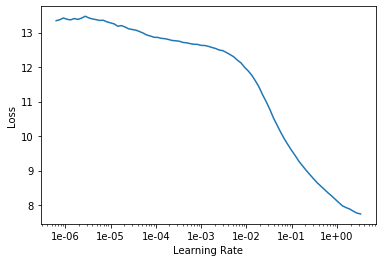

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.027949,0.026433,0.147073,02:37
1,0.019091,0.021200,0.138669,02:40
2,0.017464,0.018187,0.122957,02:41
3,0.012975,0.012326,0.107819,02:40
4,0.010869,0.012194,0.103352,02:40


In [37]:
learn.save('1')

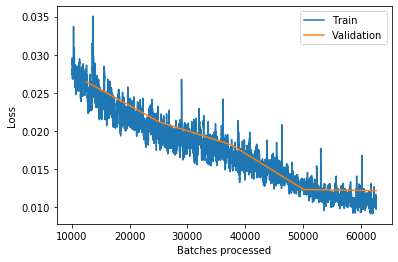

In [38]:
learn.recorder.plot_losses(skip_start=10000)

In [39]:
learn.load('1');

In [40]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013406,0.012304,0.113721,02:41
1,0.013110,0.027019,0.117421,02:39
2,0.011472,0.019728,0.116979,02:42
3,0.010888,0.015274,0.115923,02:41
4,0.008969,0.015851,0.110254,02:41


In [41]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010486,0.016555,0.115989,02:41
1,0.010797,0.049764,0.119157,02:41
2,0.010029,0.106940,0.127084,02:43
3,0.008757,0.022140,0.127931,02:42
4,0.008372,0.023584,0.119393,02:42


(10th place in the competition was 0.108)

In [42]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)